In [1]:
import numpy as np
from matplotlib import pyplot as plt
from io import StringIO
import pandas as pd
from pathlib import Path
import seaborn as sns
from ccb.experiment import parse_results
from ccb.experiment.discriminative_metric import boostrap_pw_entropy


%load_ext autoreload
%autoreload 2

# Main Restults

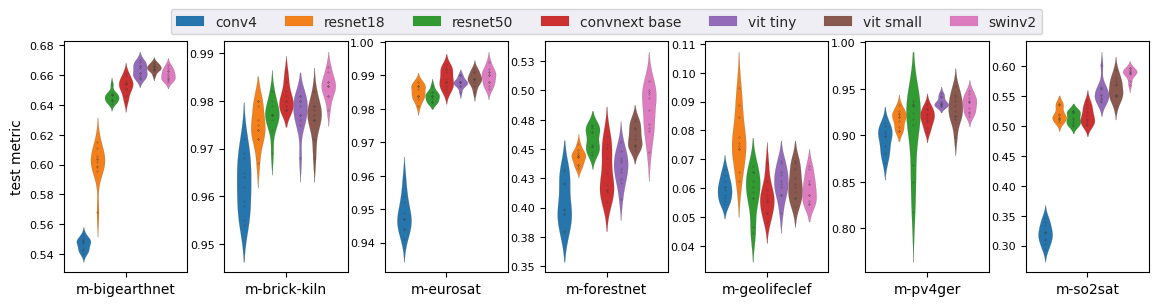

In [2]:
# sweep_results_path = "/mnt/data/experiments/nils/classification_results/sweep_results_2022-07-20_11-24-05.csv"
# df = pd.read_csv(sweep_results_path)
seeded_results_path = "/mnt/data/experiments/nils/classification_results/seeded_runs_2022-07-25_11-01-58.csv"
df = pd.read_csv(seeded_results_path)

# df['train_ratio'] = [get_train_ratio(part_name) for part_name in df['partition_name']]
df = df.applymap(parse_results.clean_names)
df = df.rename(columns=parse_results.clean_names)

model_order = "conv4,resnet18,resnet50,convnext base,vit tiny,vit small,swinv2".split(",")
ds_1x = df[df['partition name'] == '1.00x train'].copy()
normalizer = parse_results.make_normalizer(ds_1x)
normalizer.normalize_data_frame(ds_1x, ["test metric", "val metric"])


parse_results.plot_per_dataset_3(ds_1x, model_order, metric="test metric", sharey=False, inner="points", fig_size=(14,3))
plt.savefig(Path.home() / "figures" / "test metric.png", bbox_inches="tight", dpi=300)
# parse_results.plot_per_dataset_3(ds_1x, model_order, metric="val metric", sharey=False, inner="points")
# plt.savefig(Path.home() / "figures" / "test metric.png", bbox_inches="tight", dpi=300)

# parse_results.plot_per_dataset_3(ds_1x, model_order, metric="test loss", sharey=False, inner="points")
# parse_results.plot_per_dataset_3(ds_1x, model_order, metric="val loss", sharey=False, inner="points")


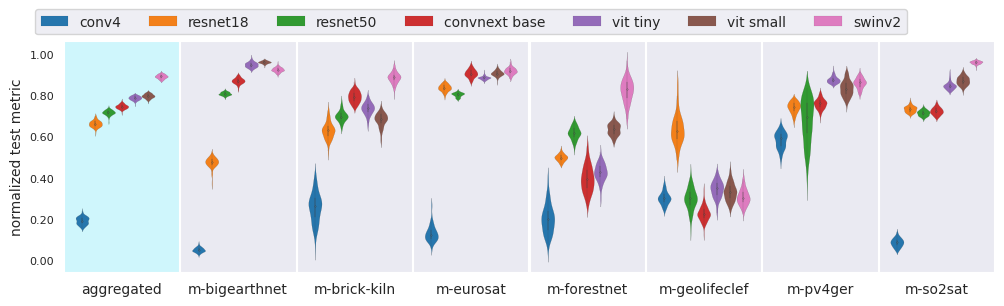

In [6]:
parse_results.plot_bootstrap_aggregate(ds_1x, metric="normalized test metric", model_order=model_order, fig_size=(12,3))
# parse_results.plot_bootstrap_aggregate(ds_1x, metric="normalized val_metric", model_order=model_order)
plt.savefig(Path.home() / "figures" / "normalized test metric.png", bbox_inches="tight", dpi=300)

# Train Size Analysis

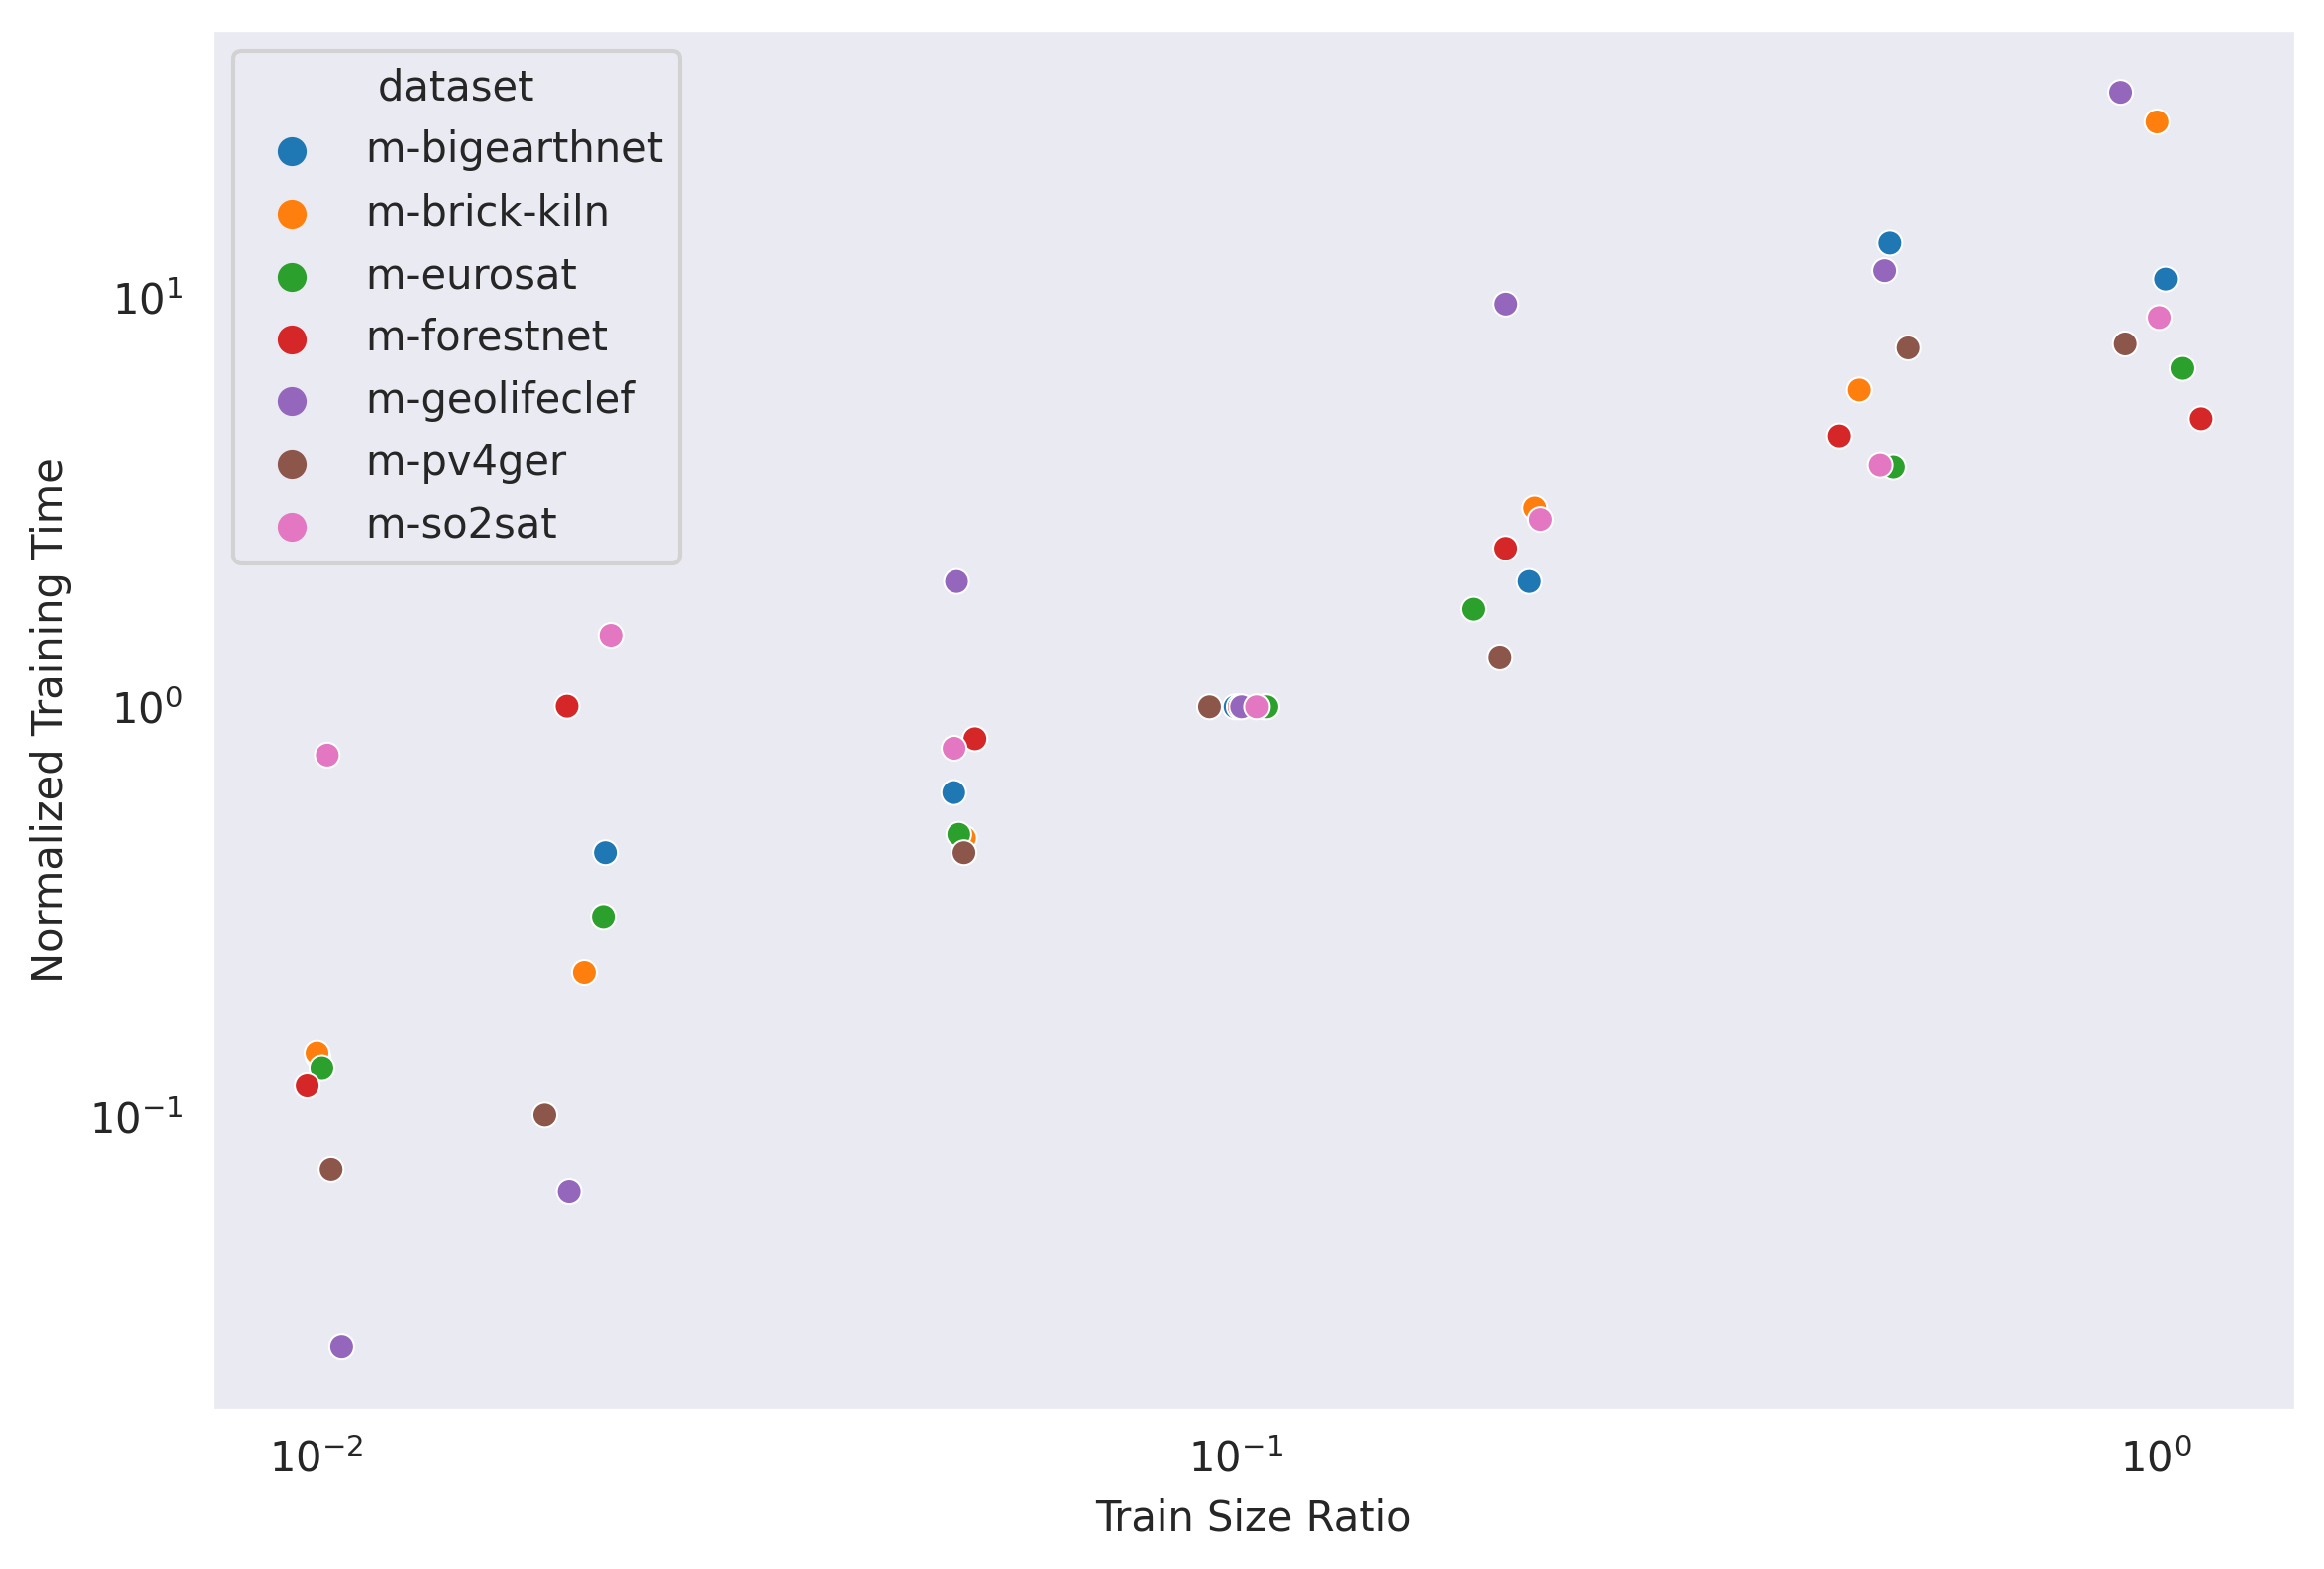

In [8]:
seeded_results_path = "/mnt/data/experiments/nils/classification_results/seeded_runs_2022-07-25_11-01-58.csv"
df = pd.read_csv(seeded_results_path)
df = df.applymap(parse_results.clean_names)
df = df.rename(columns=parse_results.clean_names)

plt.figure(figsize=(9,6), dpi=300)
parse_results.plot_normalized_time(df, average_seeds=True)
plt.savefig(Path.home() / "figures" / "training time.png", bbox_inches="tight")


m-so2sat
m-brick-kiln
m-eurosat
m-pv4ger
m-forestnet
m-bigearthnet
m-geolifeclef


<Figure size 1500x3000 with 0 Axes>

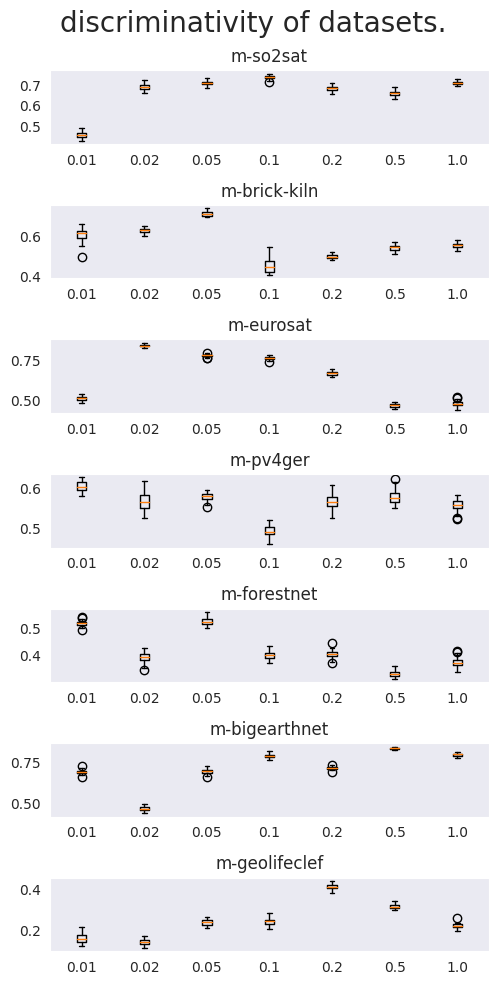

In [7]:
# old code, just keep it here for now.



def plot_discriminative_metric(df, metric="test metric", n_largest=3):
    models = df["model"].unique()
    datasets = df['dataset'].unique()
    train_ratios = np.sort(df['train ratio'].unique())

    fig, axes = plt.subplots( len(datasets), 1)
    fig.suptitle("discriminativity of datasets.", fontsize=20)
    

    for i, dataset in enumerate(datasets):

        print(dataset)
        discr_val = []
        for k, train_ratio in enumerate(train_ratios):

            # print(f"  train ratio : {train_ratio}")

            all_scores = []
            for j, model in enumerate(models):
                sub_df = df[(df["dataset"] == dataset) & (df['train ratio'] == train_ratio) & (df['model'] == model)]
                sub_df = sub_df.nlargest(n_largest, columns="val metric")
                scores = sub_df[metric].to_numpy()
                if len(scores) == 0:
                    print(f"  train ration: {train_ratio}: missing {model}")
                # print(f"    {j}: {scores}")
                all_scores.append(scores)
            
            # pw_entr = pairwise_entropy(all_scores)
            
            pw_entr_list = boostrap_pw_entropy(all_scores, repeat=50, std_ratio=0.2, replace=False)
            # print(f"    pw entr: {pw_entr}")
            axes[i].boxplot(1 - np.array(pw_entr_list), positions=[k])

            # discr_val.append(1 - pw_entr)
        
        axes[i].set_title(f"{dataset}")
        # axes[i].set_ylim((0.5,1))
        # axes[i].plot(np.arange(len(discr_val)), discr_val, marker='.')
        axes[i].set_xticklabels([str(trn_ratio) for trn_ratio in train_ratios])
    fig.tight_layout()


plt.figure(figsize=(5, 10), dpi=300)
plot_discriminative_metric(df, metric="val metric", n_largest=100)
plt.savefig(Path.home() / "figures" / "discriminativity.png", bbox_inches="tight")
